In [ ]:
# !pip install transformers

In [ ]:
# !pip install datasets

In [ ]:
from datasets import list_datasets

In [ ]:
all_datasets = list_datasets()

In [ ]:
len(all_datasets)

In [ ]:
from datasets import load_dataset

In [ ]:
emotions = load_dataset('emotion')
emotions

In [ ]:
import pandas as pd

In [ ]:
# emotions.set_format(type='pandas')

In [ ]:
df = emotions['train'][:]
df.head()

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [19]:
from transformers import DistilBertTokenizer

In [ ]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [ ]:
text = 'Tokenizing text is a core task of NLP'

In [ ]:
encoded_text = tokenizer(text)
encoded_text

In [ ]:
encoded_text2 = distilbert_tokenizer(text)
encoded_text2

In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True,
                     truncation=True)

In [ ]:
tokenize(emotions['train'][:2])

In [ ]:
tokenizer.vocab_size

In [ ]:
tokenizer.model_max_length

In [5]:
text = ['This is a test'] #, 'This is another bigger test']

In [6]:
inputs = tokenizer(text, padding=True, return_tensors='pt')

NameError: name 'tokenizer' is not defined

In [ ]:
inputs['input_ids']

In [7]:
inputs['input_ids'].size()

NameError: name 'inputs' is not defined

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

In [ ]:
outputs.last_hidden_state.size()

In [ ]:
outputs.last_hidden_state[:,0].size()

----------

In [65]:
import numpy as np
import pandas as pd
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
from datasets import load_dataset

emotions = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/ftrav/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
from transformers import AutoTokenizer

In [6]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AutoModel.from_pretrained(model_ckpt).to(device)

In [7]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [8]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\ftrav\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-c5880b300f6ca011.arrow


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\ftrav\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-03506d7ef3638bd8.arrow


In [9]:
from transformers import AutoModelForSequenceClassification

In [10]:
num_labels = 6

In [22]:
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)\
        .to(device))

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [25]:
from huggingface_hub import notebook_login

In [26]:
# notebook_login()

In [27]:
from transformers import Trainer, TrainingArguments

In [28]:
emotions_encoded.set_format('torch',
                           columns=['input_ids', 'attention_mask', 'label'])

In [29]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_gpu_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=False,
                                 log_level='error'
                                 )

In [30]:
len(emotions_encoded['train'])

16000

In [31]:
from transformers import Trainer

In [32]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

In [33]:
trainer.train()

C:\Users\ftrav\anaconda3\envs\pytorchenv\lib\site-packages\transformers\optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.876200,0.334888,0.904500,0.900787
2,0.266300,0.223563,0.925500,0.925454


TrainOutput(global_step=500, training_loss=0.5712315368652344, metrics={'train_runtime': 89.657, 'train_samples_per_second': 356.916, 'train_steps_per_second': 5.577, 'total_flos': 720342861696000.0, 'train_loss': 0.5712315368652344, 'epoch': 2.0})

In [34]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [35]:
preds_output.metrics

{'test_loss': 0.22356300055980682,
 'test_accuracy': 0.9255,
 'test_f1': 0.9254538082661607,
 'test_runtime': 1.691,
 'test_samples_per_second': 1182.734,
 'test_steps_per_second': 18.924}

In [36]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [45]:
y_preds

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

In [48]:
compute_metrics(preds_output)

{'accuracy': 0.9255, 'f1': 0.9254538082661607}

In [52]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(y_preds)

In [53]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [54]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [60]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
# df_test["label"] = df_test["label"].apply(label_int2str)
# df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [59]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,2,0,5.357092
1801,i feel that he was being overshadowed by the s...,2,0,5.276233
465,i would eventually go in to these stores but i...,1,4,5.260731
1963,i called myself pro life and voted for perry w...,1,0,5.071681
1870,i guess i feel betrayed because i admired him ...,1,0,5.001671
1274,i am going to several holiday parties and i ca...,1,0,4.969414
1950,i as representative of everything thats wrong ...,5,0,4.956354
318,i felt ashamed of these feelings and was scare...,4,0,4.859928
765,i feel super awkward and out of place right now,1,0,4.795781
1509,i guess this is a memoir so it feels like that...,1,4,4.746816


In [61]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [63]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)

In [75]:
preds_df = pd.DataFrame(preds)
preds_df['label']

0         joy
1        love
2     sadness
3       anger
4    surprise
5        fear
Name: label, dtype: object

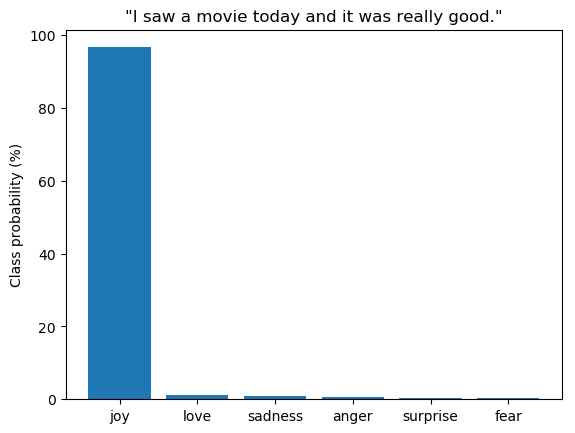

In [76]:
plt.bar(preds_df['label'], 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()